**"ПРИМЕНЕНИЕ ИСКУССТВЕННЫХ НЕЙРОННЫХ СЕТЕЙ ДЛЯ ОБРАБОТКИ ИНФОРМАЦИИ"**

**"APPLICATION OF ARTIFICIAL NEURAL NETWORKS FOR INFORMATION PROCESSING"**

In [ ]:
# @title NeuralNetwork: sum of 2 numbers

"""
Научите нейронную сеть осуществлять операцию сложения двух
чисел.
"""

# 1 - Network
import numpy as np

def initialize_parameters_deep(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1])/np.sqrt(layer_dims[l-1]) #* 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        assert (parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert (parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters

def linear_forward(A, W, b):
    Z = W.dot(A) + b

    assert (Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)

    return Z, cache


def relu(Z):
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    cache = Z
    return A, cache

def linear(Z):
    cache = Z
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):

    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation == "relu":
        A, activation_cache = relu(Z)
    elif activation == "linear":
        A, activation_cache = linear(Z)

    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "linear")
    caches.append(cache)

    assert (AL.shape == (parameters['W' + str(L)].shape[0], X.shape[1]))

    return AL, caches


def compute_cost(AL, Y, parameters, lambd):
    m = Y.shape[1]
    MSE_cost = (1 / m) * np.sum((AL - Y) ** 2)

    L2_regularization_cost = 0
    L = len(parameters) // 2
    for l in range(1, L + 1):
        L2_regularization_cost += (1 / m) * (lambd / 2) * np.sum(np.square(parameters['W' + str(l)]))

    cost = MSE_cost + L2_regularization_cost
    cost = np.squeeze(cost)
    assert (cost.shape == ())

    return cost


def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m)*np.dot(dZ, A_prev.T)
    db = (1/m)*np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)

    return dA_prev, dW, db


def relu_backward(dA, activation_cache):
    Z = activation_cache
    dZ = np.array(dA, copy=True)

    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)

    return dZ


def linear_activation_backward(dA, cache, activation):

    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "linear":
        dZ = dA

    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db


def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    dAL = AL - Y

    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "linear")

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

def update_parameters(parameters, grads, learning_rate):

    L = len(parameters) // 2

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters


# ************************************************************************************************************************************************************
# ************************************************************************************************************************************************************
# ************************************************************************************************************************************************************


# Training
def training(X, Y):
    L = [2, 1]
    parameters = initialize_parameters_deep(L)

    learning_rate = 0.0075
    num_epochs = 5000

    X = np.array(X).T
    Y = np.array(Y).reshape(1, -1)

    # train model
    for i in range(0, num_epochs):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y, parameters, lambd=0)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)

        if i % 500 == 0:
            print(f"Cost after epoch {i}: {cost}")

    return parameters


def predict(X, parameters):
    X = np.array(X).T
    probas, caches = L_model_forward(X, parameters)
    return probas


train_x = [[1, 2], [6, 9], [5, 3], [0, 6], [3, 8], [7, 4], [1, 1], [2, 5]]
train_y = [3, 15, 8, 6, 11, 11, 2, 7]

trained_parameters = training(train_x, train_y)

while True:
  print("Enter 2 numbers (separated by space): ", end="")
  test_x = list(map(float, input().split()))
  prediction = predict([test_x], trained_parameters)
  print(f"AI prediction: {prediction[0][0]}")

Cost after epoch 0: 53.756318361911624
Cost after epoch 500: 0.001179181374388454
Cost after epoch 1000: 0.00026036133384041204
Cost after epoch 1500: 5.7487359987139883e-05
Cost after epoch 2000: 1.2693115792367853e-05
Cost after epoch 2500: 2.8026193680571968e-06
Cost after epoch 3000: 6.188138082635733e-07
Cost after epoch 3500: 1.3663308462877775e-07
Cost after epoch 4000: 3.016836335230886e-08
Cost after epoch 4500: 6.661125669815817e-09
Enter 2 numbers (separated by space): -11 27
AI prediction: 15.999870785067378
Enter 2 numbers (separated by space): 1345 571
AI prediction: 1915.9862109707472
Enter 2 numbers (separated by space): 

KeyboardInterrupt: Interrupted by user

In [ ]:
# @title NeuralNetwork: small letter to big letter

"""
С помощью нейронной сети необходимо перекодировать пропис-
ные буквы в строчные (маленькие – в большие). На вход сети пода-
ется код «маленькой» буквы, с выхода «снимается» код соответст-
вующей «большой» буквы.
"""

# 1 - Network
import numpy as np

def initialize_parameters_deep(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1])/np.sqrt(layer_dims[l-1]) #* 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        assert (parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert (parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters


def linear_forward(A, W, b):
    Z = W.dot(A) + b

    assert (Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)

    return Z, cache


def softmax(Z):
  expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))
  A = expZ / np.sum(expZ, axis=0, keepdims=True)
  cache = Z
  return A, cache


def relu(Z):
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    cache = Z
    return A, cache


def linear_activation_forward(A_prev, W, b, activation):

    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation == "relu":
        A, activation_cache = relu(Z)
    elif activation == "softmax":
        A, activation_cache = softmax(Z)

    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache


def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "softmax")
    caches.append(cache)

    assert (AL.shape == (parameters['W' + str(L)].shape[0], X.shape[1])) # (1, X.shape[1])

    return AL, caches


def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = - (1 / m) * np.sum(Y * np.log(AL))
    cost = np.squeeze(cost)
    assert (cost.shape == ())

    return cost


def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m)*np.dot(dZ, A_prev.T)
    db = (1/m)*np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)

    return dA_prev, dW, db


def relu_backward(dA, activation_cache):
    Z = activation_cache
    dZ = np.array(dA, copy=True)

    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)

    return dZ


def softmax_backward(dA, activation_cache):
    return dA


def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "softmax":
        dZ = softmax_backward(dA, activation_cache)

    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db


def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    dAL = AL - Y

    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "softmax")

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

def update_parameters(parameters, grads, learning_rate):

    L = len(parameters) // 2

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters




# ************************************************************************************************************************************************************
# ************************************************************************************************************************************************************
# ************************************************************************************************************************************************************

# Training
def training(X, Y):
    L = [26, 50, 26]
    parameters = initialize_parameters_deep(L)

    learning_rate = 0.45
    num_epochs = 5000

    X = np.eye(26)[X].T
    Y = np.eye(26)[Y].T

    # train model
    for i in range(0, num_epochs):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)

        if i % 500 == 0:
            print(f"Cost after epoch {i}: {cost}")

    return parameters

def predict(X, parameters):
    X = np.eye(26)[X].reshape(26, -1)
    probas, caches = L_model_forward(X, parameters)
    return np.argmax(probas, axis=0)


train_x = [ord(ch) - ord('a') for ch in 'abcdefghijklmnopqrstuvwxyz']
train_y = [ord(ch) - ord('A') for ch in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ']


trained_parameters = training(train_x, train_y)

while True:
  print("Enter small letter: ", end="")
  test_x = ord(str(input())) - ord('a')
  prediction = predict(test_x, trained_parameters)
  print(f"AI prediction: {chr(prediction[0] + ord('A'))}")

Cost after epoch 0: 3.2427191300595752
Cost after epoch 500: 0.011532234650557182
Cost after epoch 1000: 0.004628493792137485
Cost after epoch 1500: 0.0028068802269934625
Cost after epoch 2000: 0.001987113203084985
Cost after epoch 2500: 0.0015263782121539224
Cost after epoch 3000: 0.0012331219171932749
Cost after epoch 3500: 0.00103099854945562
Cost after epoch 4000: 0.0008837511307898823
Cost after epoch 4500: 0.0007718929221264935
Enter small letter: 

KeyboardInterrupt: Interrupted by user

In [ ]:
# @title NeuralNetwork: changing tone of notes (sound)

"""
Перевод нот из одной тональности в другую называется транспо-
нированием. С помощью нейронной сети транспонируйте ноты на
один тон выше. На вход сети подается код ноты, с выхода «снима-
ется» код ноты на тон выше, октаву учитывать не нужно.
"""

# 1 - Network
import numpy as np

def initialize_parameters_deep(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1])/np.sqrt(layer_dims[l-1]) #* 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        assert (parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert (parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters

def linear_forward(A, W, b):
    Z = W.dot(A) + b

    assert (Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)

    return Z, cache


def relu(Z):
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    cache = Z
    return A, cache

def linear(Z):
    cache = Z
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):

    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation == "relu":
        A, activation_cache = relu(Z)
    elif activation == "linear":
        A, activation_cache = linear(Z)

    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "linear")
    caches.append(cache)

    assert (AL.shape == (parameters['W' + str(L)].shape[0], X.shape[1]))

    return AL, caches


def compute_cost(AL, Y, parameters, lambd):
    m = Y.shape[1]
    MSE_cost = (1 / m) * np.sum((AL - Y) ** 2)

    L2_regularization_cost = 0
    L = len(parameters) // 2
    for l in range(1, L + 1):
        L2_regularization_cost += (1 / m) * (lambd / 2) * np.sum(np.square(parameters['W' + str(l)]))

    cost = MSE_cost + L2_regularization_cost
    cost = np.squeeze(cost)
    assert (cost.shape == ())

    return cost


def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m)*np.dot(dZ, A_prev.T)
    db = (1/m)*np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)

    return dA_prev, dW, db


def relu_backward(dA, activation_cache):
    Z = activation_cache
    dZ = np.array(dA, copy=True)

    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)

    return dZ


def linear_activation_backward(dA, cache, activation):

    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "linear":
        dZ = dA

    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db


def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    dAL = AL - Y

    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "linear")

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

def update_parameters(parameters, grads, learning_rate):

    L = len(parameters) // 2

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters


# ************************************************************************************************************************************************************
# ************************************************************************************************************************************************************
# ************************************************************************************************************************************************************

import sounddevice as sd
# play note
def play_note(frequency, duration, amplitude=0.5, sample_rate=44100):
  t = np.linspace(0, duration, int(sample_rate * duration), False)
  wave = amplitude * np.sin(2 * np.pi * frequency * t)
  sd.play(wave, sample_rate)
  sd.wait()


# Training
def training(X, Y):
    L = [1, 10, 1]
    parameters = initialize_parameters_deep(L)

    learning_rate = 0.0075
    num_epochs = 5000

    X = np.array(X).reshape(1, -1)
    Y = np.array(Y).reshape(1, -1)

    # train model
    for i in range(0, num_epochs):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y, parameters, lambd=0)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)

        if i % 500 == 0:
            print(f"Cost after epoch {i}: {cost}")

    return parameters


def predict(X, parameters):
    X = np.array(X).reshape(1, -1)
    probas, caches = L_model_forward(X, parameters)
    return probas


note_frequencies = [261.63, 277.18, 293.66, 311.13, 329.63, 349.23, 369.99, 392.00, 415.30, 440.00, 466.16, 493.88]

train_x = [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11]]
train_y = [[2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [0], [1]]

trained_parameters = training(train_x, train_y)

while True:
  print("Enter note from dictionary: [0 - C(До); 1 - C#(До#); 2 - D(Ре); 3 - D#(Ре#); 4 - E(Ми); 5 - F(Фа); 6 - F#(Фа#); 7 - G(Соль); 8 - G#(Соль#); 9 - A(Ля); 10 - A#(Ля#); 11 - B(Си)]: ", end="")
  test_x = int(input())
  prediction = predict([test_x], trained_parameters)
  predicted_note = round(prediction[0][0]) % 12
  print(f"AI prediction: {predicted_note}")
  frequency = note_frequencies[predicted_note]
  play_note(frequency, 1.0)

ModuleNotFoundError: No module named 'sounddevice'

In [ ]:
# @title NeuralNetwork: degrees --> radians

"""
Реализуйте с помощью нейронной сети преобразование градусов в
радианы.
"""

# 1 - Network
import numpy as np
import math

def initialize_parameters_deep(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1])/np.sqrt(layer_dims[l-1]) #* 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        assert (parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert (parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters

def linear_forward(A, W, b):
    Z = W.dot(A) + b

    assert (Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)

    return Z, cache


def relu(Z):
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    cache = Z
    return A, cache

def linear(Z):
    cache = Z
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):

    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation == "relu":
        A, activation_cache = relu(Z)
    elif activation == "linear":
        A, activation_cache = linear(Z)

    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "linear")
    caches.append(cache)

    assert (AL.shape == (parameters['W' + str(L)].shape[0], X.shape[1]))

    return AL, caches


def compute_cost(AL, Y, parameters, lambd):
    m = Y.shape[1]
    MSE_cost = (1 / m) * np.sum((AL - Y) ** 2)

    L2_regularization_cost = 0
    L = len(parameters) // 2
    for l in range(1, L + 1):
        L2_regularization_cost += (1 / m) * (lambd / 2) * np.sum(np.square(parameters['W' + str(l)]))

    cost = MSE_cost + L2_regularization_cost
    cost = np.squeeze(cost)
    assert (cost.shape == ())

    return cost


def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m)*np.dot(dZ, A_prev.T)
    db = (1/m)*np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)

    return dA_prev, dW, db


def relu_backward(dA, activation_cache):
    Z = activation_cache
    dZ = np.array(dA, copy=True)

    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)

    return dZ


def linear_activation_backward(dA, cache, activation):

    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "linear":
        dZ = dA

    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db


def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    dAL = AL - Y

    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "linear")

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

def update_parameters(parameters, grads, learning_rate):

    L = len(parameters) // 2

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters


# ************************************************************************************************************************************************************
# ************************************************************************************************************************************************************
# ************************************************************************************************************************************************************


def normalize_data(data):
  min_val = 0
  max_val = 360
  return (data - min_val) / (max_val - min_val)


def denormalize_data(normalized_data):
  min_val = 0
  max_val = 360
  return normalized_data * (max_val - min_val) + min_val


# Training
def training(X, Y):
    L = [1, 10, 10, 1]
    parameters = initialize_parameters_deep(L)

    learning_rate = 0.55
    num_epochs = 5000

    X = np.array(X).reshape(1, -1)
    Y = np.array(Y).reshape(1, -1)


    X = normalize_data(X)
    Y = normalize_data(Y)


    # train model
    for i in range(0, num_epochs):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y, parameters, lambd=0)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)

        if i % 500 == 0:
            print(f"Cost after epoch {i}: {cost}")

    return parameters


def predict(X, parameters):
    X = np.array(X).reshape(1, -1)
    X = normalize_data(X)
    probas, caches = L_model_forward(X, parameters)
    return denormalize_data(probas)


train_x = list(range(0, 361, 10))
train_y = [x * math.pi / 180 for x in train_x]


trained_parameters = training(train_x, train_y)

while True:
  print("Enter degrees: ", end="")
  test_x = float(input())
  prediction = predict([test_x], trained_parameters)
  print(f"AI prediction: {prediction[0][0]}")

Cost after epoch 0: 0.07081275490644665
Cost after epoch 500: 2.572017410958767e-08
Cost after epoch 1000: 3.651270388809705e-09
Cost after epoch 1500: 9.610472966840762e-10
Cost after epoch 2000: 3.031882108932366e-10
Cost after epoch 2500: 2.4711211535646857e-10
Cost after epoch 3000: 2.0140947368667192e-10
Cost after epoch 3500: 1.641514583132069e-10
Cost after epoch 4000: 1.3379054213658476e-10
Cost after epoch 4500: 1.0904468536348559e-10
Enter degrees: 180
AI prediction: 3.1415981349856974
Enter degrees: 45
AI prediction: 0.7854400664214951
Enter degrees: 13
AI prediction: -0.2603330458579222
Enter degrees: 27
AI prediction: 0.4712856572796064
Enter degrees: 

KeyboardInterrupt: Interrupted by user

In [ ]:
# @title NeuralNetwork: USD --> EUR

"""
Реализуйте с помощью нейронной сети конвертер валют из долла-
ров в евро.
"""

# 1 - Network
import numpy as np
import math

def initialize_parameters_deep(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1])/np.sqrt(layer_dims[l-1]) #* 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        assert (parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert (parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters

def linear_forward(A, W, b):
    Z = W.dot(A) + b

    assert (Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)

    return Z, cache


def relu(Z):
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    cache = Z
    return A, cache

def linear(Z):
    cache = Z
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):

    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation == "relu":
        A, activation_cache = relu(Z)
    elif activation == "linear":
        A, activation_cache = linear(Z)

    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "linear")
    caches.append(cache)

    assert (AL.shape == (parameters['W' + str(L)].shape[0], X.shape[1]))

    return AL, caches


def compute_cost(AL, Y, parameters, lambd):
    m = Y.shape[1]
    MSE_cost = (1 / m) * np.sum((AL - Y) ** 2)

    L2_regularization_cost = 0
    L = len(parameters) // 2
    for l in range(1, L + 1):
        L2_regularization_cost += (1 / m) * (lambd / 2) * np.sum(np.square(parameters['W' + str(l)]))

    cost = MSE_cost + L2_regularization_cost
    cost = np.squeeze(cost)
    assert (cost.shape == ())

    return cost


def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m)*np.dot(dZ, A_prev.T)
    db = (1/m)*np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)

    return dA_prev, dW, db


def relu_backward(dA, activation_cache):
    Z = activation_cache
    dZ = np.array(dA, copy=True)

    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)

    return dZ


def linear_activation_backward(dA, cache, activation):

    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "linear":
        dZ = dA

    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db


def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    dAL = AL - Y

    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "linear")

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

def update_parameters(parameters, grads, learning_rate):

    L = len(parameters) // 2

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters


# ************************************************************************************************************************************************************
# ************************************************************************************************************************************************************
# ************************************************************************************************************************************************************


def normalize_data(data):
  min_val = 0
  max_val = 100
  return (data - min_val) / (max_val - min_val)


def denormalize_data(normalized_data):
  min_val = 0
  max_val = 100
  return normalized_data * (max_val - min_val) + min_val


# Training
def training(X, Y):
    L = [1, 10, 10, 1]
    parameters = initialize_parameters_deep(L)

    learning_rate = 0.4]
    num_epochs = 5000

    X = np.array(X).reshape(1, -1)
    Y = np.array(Y).reshape(1, -1)

    X = normalize_data(X)
    Y = normalize_data(Y)

    # train model
    for i in range(0, num_epochs):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y, parameters, lambd=0)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)

        if i % 500 == 0:
            print(f"Cost after epoch {i}: {cost}")

    return parameters


def predict(X, parameters):
    X = np.array(X).reshape(1, -1)
    X = normalize_data(X)
    probas, caches = L_model_forward(X, parameters)
    return denormalize_data(probas)


coeff = 0.92 # 1 USD = 0.92 EUR - 06.08.2024

train_x = list(range(1, 101))
train_y = [usd * coeff for usd in train_x]


trained_parameters = training(train_x, train_y)

while True:
  print("Enter USD: ", end="")
  test_x = float(input())
  prediction = predict([test_x], trained_parameters)
  print(f"AI prediction: {prediction[0][0]}")

Cost after epoch 0: 0.6260783043662594
Cost after epoch 500: 3.6695031561883604e-06
Cost after epoch 1000: 1.9055527456907374e-06
Cost after epoch 1500: 1.3465324975167663e-06
Cost after epoch 2000: 1.020586846068443e-06
Cost after epoch 2500: 7.994670505864558e-07
Cost after epoch 3000: 6.825411074103996e-07
Cost after epoch 3500: 5.727229796205432e-07
Cost after epoch 4000: 4.61518259714021e-07
Cost after epoch 4500: 3.563751728059936e-07
Enter USD: 100
AI prediction: 91.98465419715018
Enter USD: 50
AI prediction: 46.024056724264156
Enter USD: 20
AI prediction: 18.350542918516947
Enter USD: 10
AI prediction: 9.131961627471473
Enter USD: 5
AI prediction: 4.649080389132249
Enter USD: 1
AI prediction: 1.2374811441873932
Enter USD: 

KeyboardInterrupt: Interrupted by user

In [ ]:
# @title NeuralNetwork: 0.75 0.34 --> 0.34 0.75

"""
Имеется сеть с двумя входами, двумя выходами и некоторым коли-
чеством скрытых нейронов. Необходимо настроить сеть таким об-
разом, чтобы сигналы со входа менялись на выходе сети местами.
То есть, если на вход поступили числа 0,75 и 0,34, то на выходе
должны быть числа 0,34 и 0,75.
"""

# 1 - Network
import numpy as np

def initialize_parameters_deep(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1])/np.sqrt(layer_dims[l-1]) #* 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        assert (parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert (parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters

def linear_forward(A, W, b):
    Z = W.dot(A) + b

    assert (Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)

    return Z, cache


def relu(Z):
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    cache = Z
    return A, cache

def linear(Z):
    cache = Z
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):

    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation == "relu":
        A, activation_cache = relu(Z)
    elif activation == "linear":
        A, activation_cache = linear(Z)

    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "linear")
    caches.append(cache)

    assert (AL.shape == (parameters['W' + str(L)].shape[0], X.shape[1]))

    return AL, caches


def compute_cost(AL, Y, parameters, lambd):
    m = Y.shape[1]
    MSE_cost = (1 / m) * np.sum((AL - Y) ** 2)

    L2_regularization_cost = 0
    L = len(parameters) // 2
    for l in range(1, L + 1):
        L2_regularization_cost += (1 / m) * (lambd / 2) * np.sum(np.square(parameters['W' + str(l)]))

    cost = MSE_cost + L2_regularization_cost
    cost = np.squeeze(cost)
    assert (cost.shape == ())

    return cost


def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m)*np.dot(dZ, A_prev.T)
    db = (1/m)*np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)

    return dA_prev, dW, db


def relu_backward(dA, activation_cache):
    Z = activation_cache
    dZ = np.array(dA, copy=True)

    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)

    return dZ


def linear_activation_backward(dA, cache, activation):

    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "linear":
        dZ = dA

    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db


def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    dAL = AL - Y

    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "linear")

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

def update_parameters(parameters, grads, learning_rate):

    L = len(parameters) // 2

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters


# ************************************************************************************************************************************************************
# ************************************************************************************************************************************************************
# ************************************************************************************************************************************************************


# Training
def training(X, Y):
    L = [2, 10, 10, 2]
    parameters = initialize_parameters_deep(L)

    learning_rate = 0.75
    num_epochs = 5000

    X = np.array(X).T
    Y = np.array(Y).T

    # train model
    for i in range(0, num_epochs):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y, parameters, lambd=0)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)

        if i % 500 == 0:
            print(f"Cost after epoch {i}: {cost}")

    return parameters


def predict(X, parameters):
    X = np.array(X).T
    probas, caches = L_model_forward(X, parameters)
    return probas


train_x = [[0.75, 0.34], [0.16, 0.45], [0.21, 0.74], [0.58, 0.13], [0.89, 0.43], [0.7, 0.56], [0.67, 0.19], [0.23, 0.53]]
train_y = [[0.34, 0.75], [0.45, 0.16], [0.74, 0.21], [0.13, 0.58], [0.43, 0.89], [0.56, 0.7], [0.19, 0.67], [0.53, 0.23]]

trained_parameters = training(train_x, train_y)

while True:
  print("Enter 2 numbers (separated by space): ", end="")
  test_x = list(map(float, input().split()))
  prediction = predict([test_x], trained_parameters)
  print(f"AI prediction: {prediction}")

Cost after epoch 0: 0.6690032003849333
Cost after epoch 500: 0.0011477066059995414
Cost after epoch 1000: 0.000657612562757945
Cost after epoch 1500: 0.00026843881350341363
Cost after epoch 2000: 6.721528638543507e-05
Cost after epoch 2500: 0.0004345455765588294
Cost after epoch 3000: 3.548756374152087e-05
Cost after epoch 3500: 2.562417681722976e-05
Cost after epoch 4000: 1.842561443119762e-05
Cost after epoch 4500: 2.0227776335923872e-05
Enter 2 numbers (separated by space): 0.67 0.22
AI prediction: [[0.21940867]
 [0.67006798]]
Enter 2 numbers (separated by space): 

KeyboardInterrupt: Interrupted by user

In [ ]:
# @title NeuralNetwork: zodiac sign

"""
С помощью нейронной сети реализуйте определение знака зодиака
по числу и месяцу. Знак зодиака определяется по величине сигнала
выходного нейрона сети.
"""

# 1 - Network
import numpy as np

def initialize_parameters_deep(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1])/np.sqrt(layer_dims[l-1]) #* 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        assert (parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert (parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters


def linear_forward(A, W, b):
    Z = W.dot(A) + b

    assert (Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)

    return Z, cache


def softmax(Z):
  expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))
  A = expZ / np.sum(expZ, axis=0, keepdims=True)
  cache = Z
  return A, cache


def relu(Z):
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    cache = Z
    return A, cache


def linear_activation_forward(A_prev, W, b, activation):

    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation == "relu":
        A, activation_cache = relu(Z)
    elif activation == "softmax":
        A, activation_cache = softmax(Z)

    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache


def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "softmax")
    caches.append(cache)

    assert (AL.shape == (parameters['W' + str(L)].shape[0], X.shape[1])) # (1, X.shape[1])

    return AL, caches


# def compute_cost(AL, Y):
#     eps = 1e-10
#     m = Y.shape[1]
#     cost = - (1 / m) * np.sum(Y * np.log(AL + eps))
#     cost = np.squeeze(cost)
#     assert (cost.shape == ())

#     return cost


def compute_cost(AL, Y, parameters, lambd):
    m = Y.shape[1]
    cross_entropy_cost = (-1 / m) * np.sum(Y * np.log(AL + 1e-10))

    L2_regularization_cost = 0
    L = len(parameters) // 2
    for l in range(1, L + 1):
        L2_regularization_cost += (1 / m) * (lambd / 2) * np.sum(np.square(parameters['W' + str(l)]))

    cost = cross_entropy_cost + L2_regularization_cost
    cost = np.squeeze(cost)
    assert (cost.shape == ())

    return cost





def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m)*np.dot(dZ, A_prev.T)
    db = (1/m)*np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)

    return dA_prev, dW, db


def relu_backward(dA, activation_cache):
    Z = activation_cache
    dZ = np.array(dA, copy=True)

    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)

    return dZ


def softmax_backward(dA, activation_cache):
    return dA


def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "softmax":
        dZ = softmax_backward(dA, activation_cache)

    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db


def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    dAL = AL - Y

    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "softmax")

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

def update_parameters(parameters, grads, learning_rate):

    L = len(parameters) // 2

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters




# ************************************************************************************************************************************************************
# ************************************************************************************************************************************************************
# ************************************************************************************************************************************************************

# Training
def training(X, Y):
    L = [2, 50, 50, 12]
    parameters = initialize_parameters_deep(L)

    learning_rate = 0.045

    num_epochs = 10000

    X = np.array(X).T
    Y = np.eye(12)[Y].T

    # train model
    for i in range(num_epochs):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y, parameters, lambd=0)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)

        if i % 2000 == 0:
            print(f"Cost after epoch {i}: {cost}")

    return parameters


def predict(X, parameters):
    X = np.array(X).T
    probas, caches = L_model_forward(X, parameters)
    return np.argmax(probas, axis=0)




import pickle
import os

def save_parameters(parameters, filepath):
  with open(filepath, 'wb') as file:
    pickle.dump(parameters, file)


def load_parameters(filepath):
  with open(filepath, 'rb') as file:
    return pickle.load(file)


def main():
  file_path = '/content/drive/MyDrive/NeuralNetworks/NN_diff_tasks/NN_zodiac_sign/zodiac_model.pkl'

  train_x = [[20, 1], [27, 1], [11, 2], [18, 2],      # Водолей 20.1 - 18.2
              [19, 2], [24, 2], [7, 3], [20, 3],      # Рыбы 19.2 - 20.3
              [21, 3], [29, 3], [15, 4], [19, 4],     # Овен 21.3 - 19.4
              [20, 4], [23, 4], [4, 5], [20, 5],      # Телец 20.4 - 20.5
              [21, 5], [31, 5], [9, 6], [21, 6],      # Близнецы 21.5 - 21.6
              [22, 6], [25, 6], [17, 7], [22, 7],     # Рак 22.6 - 22.7
              [23, 7], [30, 7], [14, 8], [22, 8],     # Лев 23.7 - 22.8
              [23, 8], [28, 8], [16, 9], [22, 9],     # Дева 23.8 - 22.9
              [23, 9], [29, 9], [18, 10], [23, 10],   # Весы 23.9 - 23.10
              [24, 10], [31, 10], [11, 11], [22, 11], # Скорпион 24.10 - 22.11
              [23, 11], [27, 11], [8, 12], [21, 12],  # Стрелец 23.11 - 21.12
              [22, 12], [29, 12], [12, 1], [19, 1]]   # Козерог 22.12 - 19.1

  train_y = [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11]

  dictionary_zodiac = ["Водолей", "Рыбы", "Овен", "Телец", "Близнецы", "Рак", "Лев", "Дева", "Весы", "Скорпион", "Стрелец", "Козерог"]

  if os.path.exists(file_path):
    trained_parameters = load_parameters(file_path)
    print("Модель загружена из файла.")
  else:
    trained_parameters = training(train_x, train_y)
    save_parameters(trained_parameters, file_path)
    print("Модель обучена и сохранена в файл.")

  while True:
    print("Введите день и месяц через пробел: ", end="")
    try:
      test_x = list(map(int, input().split()))
      if len(test_x) != 2:
        raise ValueError("Введите только день и месяц.")
    except ValueError as e:
      print(f"Ошибка: {e}. Попробуйте снова.")
      continue
    prediction = predict([test_x], trained_parameters)
    predicted_zodiac = dictionary_zodiac[int(prediction[0])]
    print(f"AI предсказание: {predicted_zodiac}")
    print("Это правильный знак? (да/нет): ", end="")
    response = input().strip().lower()
    if response == 'нет':
      print("Введите правильный знак зодиака: ", end="")
      try:
        correct_zodiac = input().strip()
        if correct_zodiac not in dictionary_zodiac:
          raise ValueError("Некорректный знак зодиака.")
        correct_index = dictionary_zodiac.index(correct_zodiac)
      except ValueError as e:
        print(f"Ошибка: {e}. Попробуйте снова.")
        continue
      # Добавляем новый пример в обучающий набор данных
      train_x.append(test_x)
      train_y.append(correct_index)
      # Переобучаем модель на обновлённом наборе данных
      trained_parameters = training(train_x, train_y)
      save_parameters(trained_parameters, file_path)
      print("Модель обновлена и сохранена.")
    elif response == 'да':
      print("Хорошо. Продолжаем.")
      if test_x not in train_x:
        train_x.append(test_x)
        train_y.append(int(prediction[0]))
        # Переобучаем модель на обновлённом наборе данных
        trained_parameters = training(train_x, train_y)
        save_parameters(trained_parameters, file_path)
        print("Модель обновлена и сохранена. Добавлены правильно предсказанные примеры.")
    else:
      print("Ответ должен быть 'да' или 'нет'. Попробуйте снова.")

main()

Модель загружена из файла.
Введите день и месяц через пробел: 28 5
AI предсказание: Близнецы
Это правильный знак? (да/нет): да
Хорошо. Продолжаем.
Cost after epoch 0: 12.494169985675015
Cost after epoch 2000: 1.465637400559761
Cost after epoch 4000: 1.132275921086439
Cost after epoch 6000: 1.062614395553751
Cost after epoch 8000: 0.913271363796564
Модель обновлена и сохранена. Добавлены правильно предсказанные примеры.
Введите день и месяц через пробел: 09 03
AI предсказание: Рыбы
Это правильный знак? (да/нет): да
Хорошо. Продолжаем.
Cost after epoch 0: 12.333543008148634
Cost after epoch 2000: 1.3473559123935985
Cost after epoch 4000: 1.2092172030809676
Cost after epoch 6000: 1.0093084732775421
Cost after epoch 8000: 0.8700269561810785
Модель обновлена и сохранена. Добавлены правильно предсказанные примеры.
Введите день и месяц через пробел: ыы ыы
Ошибка: invalid literal for int() with base 10: 'ыы'. Попробуйте снова.
Введите день и месяц через пробел: 

KeyboardInterrupt: Interrupted by user

Cost after epoch 0: 109.14977266120933
Cost after epoch 3000: 0.305653550658289
Cost after epoch 6000: 0.1190648735359309
Cost after epoch 9000: 0.07154553792937565
Cost after epoch 12000: 0.04964220994198586
Cost after epoch 15000: 0.03719196164871048
Cost after epoch 18000: 0.030709503281556444
Cost after epoch 21000: 0.027207055330928778
Cost after epoch 24000: 0.025396251897803535
Cost after epoch 27000: 0.02461443052290511
[[ 6.45036401  4.06000186  2.53235833  2.05129168  2.49134864  3.9875433
   6.39997942 10.34241194 14.28484446]]


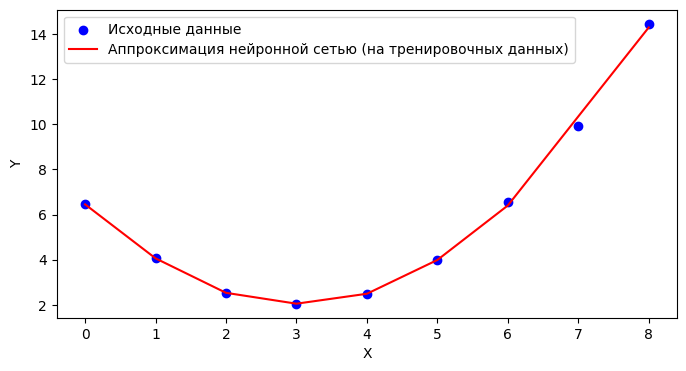

Cost after epoch 0: 100.73609783506434
Cost after epoch 5000: 0.14397551642979564
Cost after epoch 10000: 0.08180836689171361
Cost after epoch 15000: 0.048265760596335874
Cost after epoch 20000: 0.037608041766526885
Cost after epoch 25000: 0.0321322949530662
Cost after epoch 30000: 0.030367640073263386
Cost after epoch 35000: 0.030594891030599158
Cost after epoch 40000: 0.02747203071187339
Cost after epoch 45000: 0.026288123830538298
[[ 6.44014429  5.25598959  4.07183489  3.23132978  2.68602755  2.14072532
   2.02049878  2.16212617  2.47391598  3.1716656   3.86941521  4.9682139
   6.53488957  8.10156523  9.90121895 11.9843388  14.06708665]]


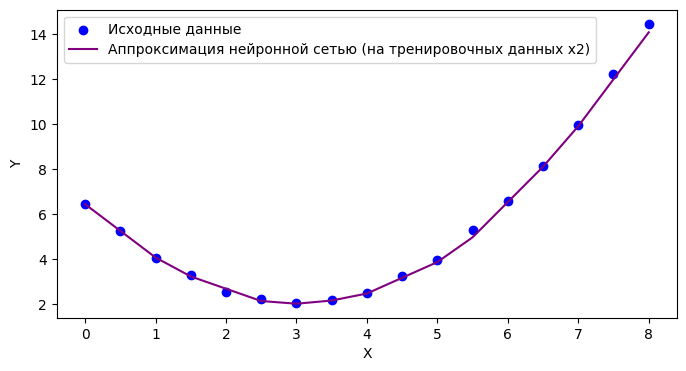

In [ ]:
# @title NeuralNetwork: approximation

"""
Дан набор точек (табл. 6).
Аппроксимируйте данную зависимость полиномом второй степени
с помощью нейронной сети. В отчете необходимо представить гра-
фик с изображением исходных точек и кривой, полученной с по-
мощью нейронной сети.
Таблица 6
X Y
0 6.45
1 4.06
2 2.53
3 2.05
4 2.48
5 3.97
6 6.57
7 9.94
8 14.45
"""

# 1 - Network
import numpy as np

def initialize_parameters_deep(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1])/np.sqrt(layer_dims[l-1]) #* 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        assert (parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert (parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters

def linear_forward(A, W, b):
    Z = W.dot(A) + b

    assert (Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)

    return Z, cache


def relu(Z):
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    cache = Z
    return A, cache

def linear(Z):
    cache = Z
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):

    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation == "relu":
        A, activation_cache = relu(Z)
    elif activation == "linear":
        A, activation_cache = linear(Z)

    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "linear")
    caches.append(cache)

    assert (AL.shape == (parameters['W' + str(L)].shape[0], X.shape[1]))

    return AL, caches


def compute_cost(AL, Y, parameters, lambd):
    m = Y.shape[1]
    MSE_cost = (1 / m) * np.sum((AL - Y) ** 2)

    L2_regularization_cost = 0
    L = len(parameters) // 2
    for l in range(1, L + 1):
        L2_regularization_cost += (1 / m) * (lambd / 2) * np.sum(np.square(parameters['W' + str(l)]))

    cost = MSE_cost + L2_regularization_cost
    cost = np.squeeze(cost)
    assert (cost.shape == ())

    return cost


def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m)*np.dot(dZ, A_prev.T)
    db = (1/m)*np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)

    return dA_prev, dW, db


def relu_backward(dA, activation_cache):
    Z = activation_cache
    dZ = np.array(dA, copy=True)

    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)

    return dZ


def linear_activation_backward(dA, cache, activation):

    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "linear":
        dZ = dA

    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db


def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    dAL = AL - Y

    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "linear")

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

def update_parameters(parameters, grads, learning_rate):

    L = len(parameters) // 2

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters


# ************************************************************************************************************************************************************
# ************************************************************************************************************************************************************
# ************************************************************************************************************************************************************


# Training
def training(X, Y, learning_rate, num_epochs, lambd, step__output__cost):
    L = [1, 25, 7, 1]
    parameters = initialize_parameters_deep(L)

    X = np.array(X).reshape(1, -1)
    Y = np.array(Y).reshape(1, -1)

    # train model
    for i in range(0, num_epochs):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y, parameters, lambd)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)

        if i % step__output__cost == 0:
            print(f"Cost after epoch {i}: {cost}")

    return parameters


def predict(X, parameters):
    X = np.array(X).reshape(1, -1)
    probas, caches = L_model_forward(X, parameters)
    return probas


train_x = [0, 1, 2, 3, 4, 5, 6, 7, 8]
train_y = [6.45, 4.06, 2.53, 2.05, 2.48, 3.97, 6.57, 9.94, 14.45]

learning_rate = 0.0057
num_epochs = 30000
lambd = 0
step__output__cost = int(num_epochs / 10)

trained_parameters = training(train_x, train_y, learning_rate, num_epochs, lambd, step__output__cost)

test_x = [0, 1, 2, 3, 4, 5, 6, 7, 8]
predictions = predict(test_x, trained_parameters)
print(predictions)

import matplotlib.pyplot as plt
# Визуализация результатов
plt.figure(figsize=(8, 4))
plt.scatter(train_x, train_y, color='blue', label='Исходные данные')
plt.plot(test_x, predictions.flatten(), color='red', label='Аппроксимация нейронной сетью (на тренировочных данных)')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()






train_x = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8]
train_y = [6.45, 5.25, 4.06, 3.31, 2.53, 2.25, 2.05, 2.2, 2.48, 3.27, 3.97, 5.31, 6.57, 8.12, 9.94, 12.24, 14.45]

learning_rate = 0.0077
num_epochs = 50000
lambd = 0
step__output__cost = int(num_epochs / 10)

trained_parameters = training(train_x, train_y, learning_rate, num_epochs, lambd, step__output__cost)

test_x = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8]
predictions = predict(test_x, trained_parameters)
print(predictions)

import matplotlib.pyplot as plt
# Визуализация результатов
plt.figure(figsize=(8, 4))
plt.scatter(train_x, train_y, color='blue', label='Исходные данные')
plt.plot(test_x, predictions.flatten(), color='purple', label='Аппроксимация нейронной сетью (на тренировочных данных x2)')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

In [ ]:
# @title NeuralNetwork: multy of 3 numbers

"""
Реализуйте с помощью нейронной сети операцию умножения трех
чисел из диапазона [0, 1].
"""

# 1 - Network
import numpy as np

def initialize_parameters_deep(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1])/np.sqrt(layer_dims[l-1]) #* 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        assert (parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert (parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters

def linear_forward(A, W, b):
    Z = W.dot(A) + b

    assert (Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)

    return Z, cache


def relu(Z):
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    cache = Z
    return A, cache

def linear(Z):
    cache = Z
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):

    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation == "relu":
        A, activation_cache = relu(Z)
    elif activation == "linear":
        A, activation_cache = linear(Z)

    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "linear")
    caches.append(cache)

    assert (AL.shape == (parameters['W' + str(L)].shape[0], X.shape[1]))

    return AL, caches


def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = (1 / m) * np.sum((AL - Y) ** 2)
    cost = np.squeeze(cost)
    assert (cost.shape == ())

    return cost


def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m)*np.dot(dZ, A_prev.T)
    db = (1/m)*np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)

    return dA_prev, dW, db


def relu_backward(dA, activation_cache):
    Z = activation_cache
    dZ = np.array(dA, copy=True)

    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)

    return dZ


def linear_activation_backward(dA, cache, activation):

    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "linear":
        dZ = dA

    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db


def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    dAL = AL - Y

    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "linear")

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

def update_parameters(parameters, grads, learning_rate):

    L = len(parameters) // 2

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters


# ************************************************************************************************************************************************************
# ************************************************************************************************************************************************************
# ************************************************************************************************************************************************************


# Training
def training(model, X, Y, learning_rate, num_epochs, batch_size, step__output__cost):
  parameters = initialize_parameters_deep(model)
  X = np.array(X).T
  Y = np.array(Y).reshape(1, -1)

  m = X.shape[1]

  for i in range(num_epochs):
    # mix data
    permutation = np.random.permutation(m) # mix indexes
    X_shuffled = X[:, permutation]
    Y_shuffled = Y[:, permutation]

    # train by batch
    for start in range(0, m, batch_size):
      end = min(start + batch_size, m)
      X_batch = X_shuffled[:, start:end]
      Y_batch = Y_shuffled[:, start:end]

      AL, caches = L_model_forward(X_batch, parameters)
      cost = compute_cost(AL, Y_batch)
      grads = L_model_backward(AL, Y_batch, caches)
      parameters = update_parameters(parameters, grads, learning_rate)

    if i % step__output__cost == 0:
      print(f"Cost after epoch {i}: {cost}")

  return parameters


def predict(X, parameters):
    X = np.array(X).T
    probas, caches = L_model_forward(X, parameters)
    return probas


# train
def generate_data_train(num_trainings):
  X = np.random.rand(num_trainings, 3)
  y = np.prod(X, axis=1)
  return X, y



# hyper_parameters
model = [3, 64, 64, 1]
num_trainings = 100000
train_x, train_y = generate_data_train(num_trainings)
learning_rate = 0.45
num_epochs = 50
batch_size = 64
step__output__cost = int(num_epochs / 10)

trained_parameters = training(model, train_x, train_y, learning_rate, num_epochs, batch_size, step__output__cost)




# TESTING

# test = train
predictions = predict(train_x, trained_parameters)
mse = 0
for i in range(num_trainings):
  mse += (predictions[0][i] - train_y[i]) ** 2
mse = mse / num_trainings
print("test = train.")
print(f"MSE: {mse}")



# test = generate_test()
def generate_data_test(number_of_tests):
  X = np.random.rand(number_of_tests, 3)
  y = np.prod(X, axis=1)
  return X, y
print("your number of tests for generate test: ", end="")
number_of_tests = int(input())
test_x, test_y = generate_data_test(number_of_tests)
predictions = predict(test_x, trained_parameters)
mse = 0
for i in range(number_of_tests):
  mse += (predictions[0][i] - test_y[i]) ** 2
mse = mse / number_of_tests
print("test = generate_data_test('your number of tests').")
print(f"MSE: {mse}")



# your test
while True:
  print("Enter 3 numbers (separated by space): ", end="")
  test_x = list(map(float, input().split()))
  prediction = predict([test_x], trained_parameters)
  print(f"AI prediction: {prediction[0][0]}")

Cost after epoch 0: 0.00018341393354883627
Cost after epoch 5: 0.00020022017790101838
Cost after epoch 10: 2.1761043993672953e-05
Cost after epoch 15: 1.8860271516598575e-05
Cost after epoch 20: 1.439067552437231e-05
Cost after epoch 25: 4.681783036586692e-05
Cost after epoch 30: 1.4073439828532631e-05
Cost after epoch 35: 1.377324322407068e-05
Cost after epoch 40: 1.555303907498295e-05
Cost after epoch 45: 1.7623411041428075e-05
test = train.
MSE: 1.4422870715815148e-05
your number of tests for generate test: 100
test = generate_data_test('your number of tests').
MSE: 1.5973760309137634e-05
Enter 3 numbers (separated by space): 0.5 0.5 0.5
AI prediction: 0.12913661145471977
Enter 3 numbers (separated by space): 0.3 0.2 0.1
AI prediction: 0.00861345029837389
Enter 3 numbers (separated by space): 0.2 0.2 0.2
AI prediction: 0.009246088228019603
Enter 3 numbers (separated by space): 0.3 0.3 0.3
AI prediction: 0.034728399809098545
Enter 3 numbers (separated by space): 

KeyboardInterrupt: Interrupted by user

In [ ]:
# @title NeuralNetwork: prediction (sinusoid)

"""
На основании данных из табл.7 продолжите числовой ряд с помо-
щью механизма предсказания на основе нейронной сети. Ряд может
содержать отрицательные числа.
Таблица 7
| 0,707 | 0,866 | 0,966 | 1 | 0,966 | 0,866 | 0,707 | 0,5 | 0,259 | 0 | –0,259 |
Правильный ответ: | –0.5 | –0.707 | … (синусоида)
"""

# 1 - Network
import numpy as np

def initialize_parameters_deep(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1])/np.sqrt(layer_dims[l-1]) #* 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        assert (parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert (parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters

def linear_forward(A, W, b):
    Z = W.dot(A) + b

    assert (Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)

    return Z, cache


def relu(Z):
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    cache = Z
    return A, cache

def linear(Z):
    cache = Z
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):

    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation == "relu":
        A, activation_cache = relu(Z)
    elif activation == "linear":
        A, activation_cache = linear(Z)

    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "linear")
    caches.append(cache)

    assert (AL.shape == (parameters['W' + str(L)].shape[0], X.shape[1]))

    return AL, caches


def compute_cost(AL, Y, parameters, lambd):
    m = Y.shape[1]
    cost_mse = (1 / m) * np.sum((AL - Y) ** 2)

    L2_regularization_cost = 0
    L = len(parameters) // 2
    for l in range(1, L + 1):
        L2_regularization_cost += (1 / m) * (lambd / 2) * np.sum(np.square(parameters['W' + str(l)]))

    cost = cost_mse + L2_regularization_cost
    cost = np.squeeze(cost)
    assert (cost.shape == ())

    return cost


def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m)*np.dot(dZ, A_prev.T)
    db = (1/m)*np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)

    return dA_prev, dW, db


def relu_backward(dA, activation_cache):
    Z = activation_cache
    dZ = np.array(dA, copy=True)

    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)

    return dZ


def linear_activation_backward(dA, cache, activation):

    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "linear":
        dZ = dA

    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db


def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    dAL = AL - Y

    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "linear")

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

def update_parameters(parameters, grads, learning_rate):

    L = len(parameters) // 2

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters


# ************************************************************************************************************************************************************
# ************************************************************************************************************************************************************
# ************************************************************************************************************************************************************


# Training
def training(model, X, Y, learning_rate, num_epochs, batch_size, lambd, step__output__cost, flag__output):
  parameters = initialize_parameters_deep(model)
  X = np.array(X).T
  Y = np.array(Y).reshape(1, -1)

  m = X.shape[1]

  for i in range(num_epochs):
    # mix data
    permutation = np.random.permutation(m) # mix indexes
    X_shuffled = X[:, permutation]
    Y_shuffled = Y[:, permutation]

    # train by batch
    for start in range(0, m, batch_size):
      end = min(start + batch_size, m)
      X_batch = X_shuffled[:, start:end]
      Y_batch = Y_shuffled[:, start:end]

      AL, caches = L_model_forward(X_batch, parameters)
      cost = compute_cost(AL, Y_batch, parameters, lambd)
      grads = L_model_backward(AL, Y_batch, caches)
      parameters = update_parameters(parameters, grads, learning_rate)


    if i % step__output__cost == 0 and flag__output:
      print(f"Cost after epoch {i}: {cost}")

  return parameters


def predict(X, parameters):
    X = np.array(X).T
    probas, caches = L_model_forward(X, parameters)
    return probas








def prepare_data(sequence, n_steps):
  X, y = [], []
  for i in range(len(sequence)):
    end_ix = i + n_steps
    if end_ix > len(sequence)-1:
      break
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

row = [0.707,  0.866, 0.966, 1, 0.966, 0.866, 0.707, 0.5, 0.259, 0, -0.259]     # answer: -0.5, -0.707, ... (sinusoid)
n_steps = 3
train_x, train_y = prepare_data(row, n_steps)



def print_array(array):
  for i in range(len(array)):
    print(f"{array[i]:7.4}", end="  ")
  print()





# hyper_parameters
num_trainings = len(train_x)
model = [n_steps, 10, 1]

learning_rate = 0.067 #0.067
num_epochs = 500
batch_size = 2
lambd = 0
step__output__cost = int(num_epochs / 10)
flag__output = True

trained_parameters = training(model, train_x, train_y, learning_rate, num_epochs, batch_size, lambd, step__output__cost, flag__output)




# TESTING
# test = train
predictions = predict(train_x, trained_parameters)
mse = 0
for i in range(num_trainings):
  mse += (predictions[0][i] - train_y[i]) ** 2
mse = mse / num_trainings
print("test = train.")
print(f"MSE: {mse}")
print("prediction: ", end="")
print_array(predictions[0])
print("true labels: ", end="")
print_array(train_y)
print("-----------------------------------------------------------------------------------------")







# test = 0.707,  0.866, 0.966, 1, 0.966, 0.866, 0.707, 0.5, 0.259, 0, -0.259, ... (sinusoid)
# answer: -0.5, -0.707, ... (sinusoid)
test_x = [[0.259, 0, -0.259]]
test_y = [-0.5]
predictions = predict(test_x, trained_parameters)
print("test = 0.707,  0.866, 0.966, 1, 0.966, 0.866, 0.707, 0.5, 0.259, 0, -0.259, ... (sinusoid)")
print("prediction: ", end="")
print_array(predictions[0])
print("true labels: ", end="")
print_array(test_y)
print("-----------------------------------------------------------------------------------------")


row.append(-0.5)
n_steps = 4
train_x, train_y = prepare_data(row, n_steps)
model = [n_steps, 10, 1]
num_epochs = 1500
learning_rate = 0.75
lambd = 0
trained_parameters = training(model, train_x, train_y, learning_rate, num_epochs, batch_size, lambd, step__output__cost, flag__output)


# test = 0.707,  0.866, 0.966, 1, 0.966, 0.866, 0.707, 0.5, 0.259, 0, -0.259, -0.5, ... (sinusoid)
# answer: -0.707, ... (sinusoid)
test_x = [[0.259, 0, -0.259, -0.5]]
test_y = [-0.707]
predictions = predict(test_x, trained_parameters)
print("test = 0.707,  0.866, 0.966, 1, 0.966, 0.866, 0.707, 0.5, 0.259, 0, -0.259, -0.5, ... (sinusoid)")
print("prediction: ", end="")
print_array(predictions[0])
print("true labels: ", end="")
print_array(test_y)
print("-----------------------------------------------------------------------------------------")

Cost after epoch 0: 0.6190698864286461
Cost after epoch 50: 0.005661881548490019
Cost after epoch 100: 0.002421242324516498
Cost after epoch 150: 5.768663763150944e-05
Cost after epoch 200: 0.0003646076060640935
Cost after epoch 250: 0.000197577161685433
Cost after epoch 300: 3.6649947001529685e-05
Cost after epoch 350: 3.307649119578395e-05
Cost after epoch 400: 8.44163166774804e-06
Cost after epoch 450: 3.5265940102007175e-06
test = train.
MSE: 1.3192604668345885e-06
prediction:  0.9981   0.9655   0.8668   0.7084   0.5013   0.2599  0.000406  -0.2602  
true labels:     1.0    0.966    0.866    0.707      0.5    0.259      0.0   -0.259  
-----------------------------------------------------------------------------------------
test = 0.707,  0.866, 0.966, 1, 0.966, 0.866, 0.707, 0.5, 0.259, 0, -0.259, ... (sinusoid)
prediction: -0.5265  
true labels:    -0.5  
-----------------------------------------------------------------------------------------
Cost after epoch 0: 0.6407592811635379

In [ ]:
# @title NeuralNetwork: classification objects

"""
Создайте нейронную сеть, которая правильно классифицирует объ-
екты, пользуясь данными из табл. 8.
Ответ: Если «Параметр 1» = 1, то 1-й класс, если «Параметр 2» =
«Параметр 3», то 2-й класс, в противном случае – 3-й класс.
Таблица 8
Объект  Параметр_1   Параметр_2  Параметр_3   Класс
  1        1             1            0         1
  2        1             0            1         1
  3        0             1            1         2
  4        0             1            0         3
  5        0             1            1         2
  6        0             0            1         3
  7        0             1            0         3
  8        1             1            1         1
  9        0             0            0         2
"""

# 1 - Network
import numpy as np

def initialize_parameters_deep(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1])/np.sqrt(layer_dims[l-1]) #* 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        assert (parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert (parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters


def linear_forward(A, W, b):
    Z = W.dot(A) + b

    assert (Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)

    return Z, cache


def softmax(Z):
  expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))
  A = expZ / np.sum(expZ, axis=0, keepdims=True)
  cache = Z
  return A, cache


def relu(Z):
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    cache = Z
    return A, cache


def linear_activation_forward(A_prev, W, b, activation):

    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation == "relu":
        A, activation_cache = relu(Z)
    elif activation == "softmax":
        A, activation_cache = softmax(Z)

    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache


def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "softmax")
    caches.append(cache)

    assert (AL.shape == (parameters['W' + str(L)].shape[0], X.shape[1])) # (1, X.shape[1])

    return AL, caches


def compute_cost(AL, Y, parameters, lambd):
    m = Y.shape[1]
    cross_entropy_cost = (-1 / m) * np.sum(Y * np.log(AL))

    L2_regularization_cost = 0
    L = len(parameters) // 2
    for l in range(1, L + 1):
        L2_regularization_cost += (1 / m) * (lambd / 2) * np.sum(np.square(parameters['W' + str(l)]))

    cost = cross_entropy_cost + L2_regularization_cost
    cost = np.squeeze(cost)
    assert (cost.shape == ())

    return cost





def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m)*np.dot(dZ, A_prev.T)
    db = (1/m)*np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)

    return dA_prev, dW, db


def relu_backward(dA, activation_cache):
    Z = activation_cache
    dZ = np.array(dA, copy=True)

    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)

    return dZ


def softmax_backward(dA, activation_cache):
    return dA


def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "softmax":
        dZ = softmax_backward(dA, activation_cache)

    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db


def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    dAL = AL - Y

    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "softmax")

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

def update_parameters(parameters, grads, learning_rate):

    L = len(parameters) // 2

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters




# ************************************************************************************************************************************************************
# ************************************************************************************************************************************************************
# ************************************************************************************************************************************************************




# Training
def training(model, X, Y, learning_rate, num_epochs, batch_size, lambd, step__output__cost, flag__output):
  parameters = initialize_parameters_deep(model)
  X = np.array(X).T
  Y = np.eye(3)[Y].T

  m = X.shape[1]

  for i in range(num_epochs):
    # mix data
    permutation = np.random.permutation(m) # mix indexes
    X_shuffled = X[:, permutation]
    Y_shuffled = Y[:, permutation]

    # train by batch
    for start in range(0, m, batch_size):
      end = min(start + batch_size, m)
      X_batch = X_shuffled[:, start:end]
      Y_batch = Y_shuffled[:, start:end]

      AL, caches = L_model_forward(X_batch, parameters)
      cost = compute_cost(AL, Y_batch, parameters, lambd)
      grads = L_model_backward(AL, Y_batch, caches)
      parameters = update_parameters(parameters, grads, learning_rate)


    if i % step__output__cost == 0 and flag__output:
      print(f"Cost after epoch {i}: {cost}")

  return parameters


#
def print_array(array):
  for j in range(len(array)):
    for i in range(len(array[j])):
      print(f"{array[j][i]:10.3}", end="  ")
    print()
  print()
#


def predict(X, parameters):
    X = np.array(X).T
    probas, caches = L_model_forward(X, parameters)
    print_array(probas)
    return np.argmax(probas, axis=0)






def normalize_data_for_OneHot(data):
  for i in range(len(data)):
    data[i] -= 1
  return data


def denormalize_data_from_OneHot(data):
  for i in range(len(data)):
    data[i] += 1
  return data


train_x = [[1, 1, 0], [1, 0, 1], [0, 1, 1], [0, 1, 0], [0, 1, 1], [0, 0, 1]]
train_y = [1, 1, 2, 3, 2, 3]


# normalize elements from Y: -1 - because one-hot indexes: '0', 1, 2, 3, 4, ...
train_y = normalize_data_for_OneHot(train_y)

# hyperparameters
model = [3, 64, 64, 3]
learning_rate = 0.045 #0.067
num_epochs = 3000
batch_size = 1
lambd = 0
step__output__cost = int(num_epochs / 10)
flag__output = True

trained_parameters = training(model, train_x, train_y, learning_rate, num_epochs, batch_size, lambd, step__output__cost, flag__output)

predictions = predict(train_x, trained_parameters)

# denormalize elements and print result
predictions = denormalize_data_from_OneHot(predictions)
train_y = denormalize_data_from_OneHot(train_y)
train_y = np.array(train_y)
print("test = train", end="\n")
print("predictions: ", end="")
print(predictions)
print("true labels: ", end="")
print(train_y)




test_x = [[1, 1, 0], [1, 0, 1], [0, 1, 1], [0, 1, 0], [0, 1, 1], [0, 0, 1], [0, 1, 0], [1, 1, 1], [0, 0, 0]]
test_y = [1, 1, 2, 3, 2, 3, 3, 1, 2]


# normalize elements from Y: -1 - because one-hot indexes: '0', 1, 2, 3, 4, ...
test_y = normalize_data_for_OneHot(test_y)

predictions = predict(test_x, trained_parameters)

# denormalize elements and print result
predictions = denormalize_data_from_OneHot(predictions)
test_y = denormalize_data_from_OneHot(test_y)
test_y = np.array(test_y)
print("test = 9 objects: [1, 1, 0], [1, 0, 1], [0, 1, 1], [0, 1, 0], [0, 1, 1], [0, 0, 1], [0, 1, 0], [1, 1, 1], [0, 0, 0]", end="\n")
print("predictions: ", end="")
print(predictions)
print("true labels: ", end="")
print(test_y)

Cost after epoch 0: 1.4345823888834264
Cost after epoch 300: 0.0006240052812288457
Cost after epoch 600: 0.0004017133911972183
Cost after epoch 900: 0.0002431368235503163
Cost after epoch 1200: 8.180558888205725e-05
Cost after epoch 1500: 0.0002660057993961795
Cost after epoch 1800: 5.088430971909152e-05
Cost after epoch 2100: 8.732404809314025e-05
Cost after epoch 2400: 7.448831066059677e-05
Cost after epoch 2700: 6.485253425530339e-05
       1.0         1.0    2.83e-07    4.24e-05    2.83e-07    5.94e-05  
  2.69e-06     1.6e-07         1.0    7.32e-05         1.0    8.22e-05  
  2.54e-05    3.89e-05     5.7e-05         1.0     5.7e-05         1.0  

test = train
predictions: [1 1 2 3 2 3]
true labels: [1 1 2 3 2 3]
       1.0         1.0    2.83e-07    4.24e-05    2.83e-07    5.94e-05    4.24e-05       0.967      0.0653  
  2.69e-06     1.6e-07         1.0    7.32e-05         1.0    8.22e-05    7.32e-05      0.0334     0.00829  
  2.54e-05    3.89e-05     5.7e-05         1.0     5.7

In [ ]:
# @title NeuralNetwork: NN-controller...

"""
Имеется физическая система с переменными объемом и внутренним
давлением. Необходимо создать нейросетевой регулятор, поддержи-
вающий постоянную температуру внутри этой системы. На вход ре-
гулятора подается изменение давления и объема, на выходе – изме-
нение температуры, компенсирующее действие изменяющихся па-
раметров. Начальные условия: V0=15 дм3, P0=100 Па, Т0=280o К.
Расчет требуемого изменения температуры производится по фор-
муле:
"""


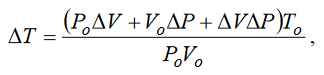

In [ ]:
# @title NeuralNetwork: ...NN-controller
# 1 - Network
import numpy as np

def initialize_parameters_deep(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1])/np.sqrt(layer_dims[l-1]) #* 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        assert (parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert (parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters

def linear_forward(A, W, b):
    Z = W.dot(A) + b

    assert (Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)

    return Z, cache


def relu(Z):
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    cache = Z
    return A, cache

def linear(Z):
    cache = Z
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):

    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation == "relu":
        A, activation_cache = relu(Z)
    elif activation == "linear":
        A, activation_cache = linear(Z)

    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "linear")
    caches.append(cache)

    assert (AL.shape == (parameters['W' + str(L)].shape[0], X.shape[1]))

    return AL, caches


def compute_cost(AL, Y, parameters, lambd):
    m = Y.shape[1]
    cost_mse = (1 / m) * np.sum((AL - Y) ** 2)

    L2_regularization_cost = 0
    L = len(parameters) // 2
    for l in range(1, L + 1):
        L2_regularization_cost += (1 / m) * (lambd / 2) * np.sum(np.square(parameters['W' + str(l)]))

    cost = cost_mse + L2_regularization_cost
    cost = np.squeeze(cost)
    assert (cost.shape == ())

    return cost


def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m)*np.dot(dZ, A_prev.T)
    db = (1/m)*np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)

    return dA_prev, dW, db


def relu_backward(dA, activation_cache):
    Z = activation_cache
    dZ = np.array(dA, copy=True)

    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)

    return dZ


def linear_activation_backward(dA, cache, activation):

    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "linear":
        dZ = dA

    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db


def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    dAL = AL - Y

    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "linear")

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

def update_parameters(parameters, grads, learning_rate):

    L = len(parameters) // 2

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters


# ************************************************************************************************************************************************************
# ************************************************************************************************************************************************************
# ************************************************************************************************************************************************************


# Training
def training(model, X, Y, learning_rate, num_epochs, batch_size, lambd, step__output__cost, flag__output):
  parameters = initialize_parameters_deep(model)
  X = np.array(X).T
  Y = np.array(Y).reshape(1, -1)

  m = X.shape[1]

  for i in range(num_epochs):
    # mix data
    permutation = np.random.permutation(m) # mix indexes
    X_shuffled = X[:, permutation]
    Y_shuffled = Y[:, permutation]

    # train by batch
    for start in range(0, m, batch_size):
      end = min(start + batch_size, m)
      X_batch = X_shuffled[:, start:end]
      Y_batch = Y_shuffled[:, start:end]

      AL, caches = L_model_forward(X_batch, parameters)
      cost = compute_cost(AL, Y_batch, parameters, lambd)
      grads = L_model_backward(AL, Y_batch, caches)
      parameters = update_parameters(parameters, grads, learning_rate)


    if i % step__output__cost == 0 and flag__output:
      print(f"Cost after epoch {i}: {cost}")

  return parameters


def predict(X, parameters):
    X = np.array(X).T
    probas, caches = L_model_forward(X, parameters)
    return probas








# const
V0 = 15 # дм^3
P0 = 100 # Па
T0 = 280 # K

# generate datasets
np.random.seed(0)
num_trainings = 1000

delta_V = np.random.uniform(-5, 5, num_trainings) # [-5, 5] дм^3
delta_P = np.random.uniform(-50, 50, num_trainings) # [-50, 50] Па

# deltaT
delta_T = (P0 * delta_V + V0 * delta_P + delta_V * delta_P) * T0 / (P0 * V0)

# prepare data
train_x = np.column_stack((delta_P, delta_V))
train_y = delta_T




from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)




def print_array(array):
  for i in range(len(array)):
    print(f"{array[i]:7.4}", end="  ")
  print()





# hyper_parameters
model = [2, 64, 64, 1]

learning_rate = 0.001 #0.067
num_epochs = 10000
batch_size = 32
lambd = 0
step__output__cost = int(num_epochs / 10)
flag__output = True

trained_parameters = training(model, train_x, train_y, learning_rate, num_epochs, batch_size, lambd, step__output__cost, flag__output)




# TESTING
# test = train
predictions = predict(train_x, trained_parameters)
mse = 0
for i in range(num_trainings):
  mse += (predictions[0][i] - train_y[i]) ** 2
mse = mse / num_trainings
print("test = train.")
print(f"MSE: {mse}")
print("predictions: ", end="")
print_array(predictions[0])
print("true labels: ", end="")
print_array(train_y)
print("-----------------------------------------------------------------------------------------")




# test = generate_random_test
number_of_tests = 100
delta_V_test = np.random.uniform(-5, 5, number_of_tests)
delta_P_test = np.random.uniform(-50, 50, number_of_tests)
test_x = np.column_stack((delta_P_test, delta_V_test))
delta_T_test = (P0 * delta_V_test + V0 * delta_P_test + delta_V_test * delta_P_test) * T0 / (P0 * V0)
test_y = delta_T_test


scaler = StandardScaler()
test_x = scaler.fit_transform(test_x)


predictions = predict(test_x, trained_parameters)
mse = 0
for i in range(number_of_tests):
  mse += (predictions[0][i] - test_y[i]) ** 2
mse = mse / number_of_tests
print("test = generate_random_test")
print(f"MSE: {mse}")
print("predictions: ", end="")
print_array(predictions[0])
print("true labels: ", end="")
print_array(test_y)
print("-----------------------------------------------------------------------------------------")

Cost after epoch 0: 153.14404755870967
Cost after epoch 1000: 0.08668445124719103
Cost after epoch 2000: 0.13762045676178072
Cost after epoch 3000: 0.3490568936098678
Cost after epoch 4000: 0.043574869150815834
Cost after epoch 5000: 0.060126702185613605
Cost after epoch 6000: 0.02245525656919749
Cost after epoch 7000: 0.12458715456416333
Cost after epoch 8000: 0.02342614029218183
Cost after epoch 9000: 0.11692114328516706
test = train.
MSE: 0.05362397281958524
predictions:   35.79   -116.7    12.05    68.49   -135.4    143.5   -6.122   -92.82   -14.68    95.11    81.42   -106.7   -49.42    63.42   -175.9   -94.86   -91.39   -25.51    80.71    156.8    -8.49    96.13    30.86    201.1   -12.79    132.6   -68.48   -31.41    144.7   -113.8   -50.66   -91.75    112.3    148.6    -47.9   -23.41   -53.04   -49.04   -52.68    42.02   -117.0   -61.09    76.81   -36.76   -116.9    9.825   -19.51    5.386   -40.38    93.86   -55.74   -142.0    84.92   -124.5    18.83   -121.1   -29.75    21.96 

Cost after epoch 0: 4.875942554565427
Cost after epoch 100: 2.1216128065233812
Cost after epoch 200: 1.0324741966623732
Cost after epoch 300: 0.5918004499979991
Cost after epoch 400: 0.350706308852893
Cost after epoch 500: 0.2530786446994174
Cost after epoch 600: 0.1728028590801662
Cost after epoch 700: 0.14639639944269156
Cost after epoch 800: 0.11858104713532922
Cost after epoch 900: 0.09046170313680903
MSE_COMPRESSED: 0.0011812608218406922
Cost after epoch 0: 65.63159835931609
Cost after epoch 100: 55.353755174820506
Cost after epoch 200: 43.164474830544584
Cost after epoch 300: 35.13723901119027
Cost after epoch 400: 29.672578982544234
Cost after epoch 500: 26.130993237739034
Cost after epoch 600: 22.144683522685686
Cost after epoch 700: 18.581652864505887
Cost after epoch 800: 16.22393830432612
Cost after epoch 900: 14.493858109063565
MSE_RESTORED: 0.04811157916213814


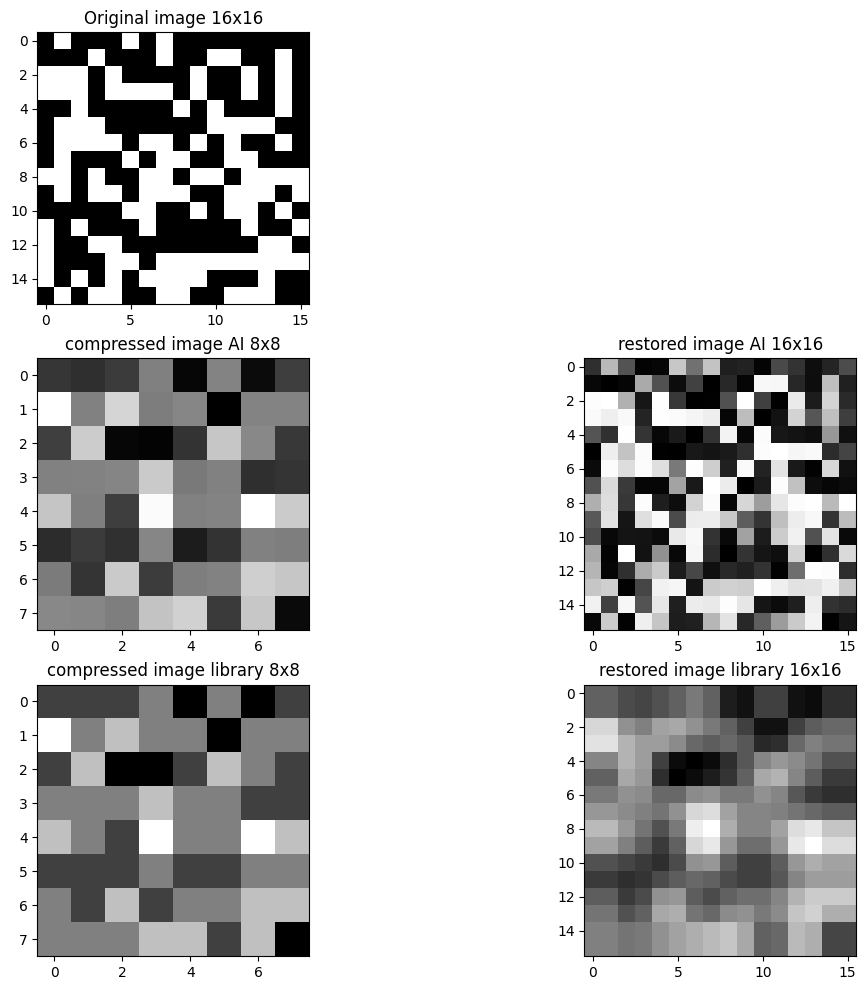

In [ ]:
# @title NeuralNetwork: image compression (k=2)

"""
Реализуйте с помощью нейронной сети сжатие бинарных изобра-
жений размером 16х16 пикселей с коэффициентом сжатия 2.
"""

# 1 - Network
import numpy as np


def initialize_parameters_deep(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1])/np.sqrt(layer_dims[l-1]) #* 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        assert (parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert (parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters


def linear_forward(A, W, b):
    Z = W.dot(A) + b

    assert (Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)

    return Z, cache


def sigmoid(Z):
    A = 1/(1 + np.exp(-Z))
    cache = Z
    return A, cache


def relu(Z):
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    cache = Z
    return A, cache


def linear_activation_forward(A_prev, W, b, activation):

    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation == "relu":
        A, activation_cache = relu(Z)
    elif activation == "sigmoid":
        A, activation_cache = sigmoid(Z)

    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)

    assert (AL.shape == (parameters['W' + str(L)].shape[0], X.shape[1])) # (1, X.shape[1])

    return AL, caches


# def compute_cost(AL, Y, parameters, lambd):
#     m = Y.shape[1]

#     eps = 1e-8
#     BCE_cost = (-1/m) * (np.dot(Y, np.log(AL + eps).T) + np.dot((1 - Y), np.log(1 - AL + eps).T))

#     L2_regularization_cost = 0
#     L = len(parameters) // 2
#     for l in range(1, L + 1):
#         L2_regularization_cost += (1 / m) * (lambd / 2) * np.sum(np.square(parameters['W' + str(l)]))

#     cost = BCE_cost + L2_regularization_cost
#     print(cost.shape)
#     cost = np.squeeze(cost)
#     assert (cost.shape == ())

#     return cost




def compute_cost(AL, Y, parameters, lambd):
    m = Y.shape[1]
    cost_mse = (1 / m) * np.sum((AL - Y) ** 2)

    L2_regularization_cost = 0
    L = len(parameters) // 2
    for l in range(1, L + 1):
        L2_regularization_cost += (1 / m) * (lambd / 2) * np.sum(np.square(parameters['W' + str(l)]))

    cost = cost_mse + L2_regularization_cost
    cost = np.squeeze(cost)
    assert (cost.shape == ())

    return cost







def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m)*np.dot(dZ, A_prev.T)
    db = (1/m)*np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)

    return dA_prev, dW, db


def relu_backward(dA, activation_cache):
    Z = activation_cache
    dZ = np.array(dA, copy=True)

    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)

    return dZ


def sigmoid_backward(dA, activation_cache):
    Z = activation_cache
    s = 1/(1 + np.exp(-Z))

    dZ = dA*s*(1-s)
    assert (dZ.shape == Z.shape)

    return dZ


def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)

    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db


def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    dAL = AL - Y

    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

def update_parameters(parameters, grads, learning_rate):

    L = len(parameters) // 2

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters




# ************************************************************************************************************************************************************
# ************************************************************************************************************************************************************
# ************************************************************************************************************************************************************




# Training
def training(model, X, Y, learning_rate, num_epochs, batch_size, lambd, step__output__cost, flag__output):
  parameters = initialize_parameters_deep(model)
  X = np.array(X).T
  Y = np.array(Y).T

  m = X.shape[1]

  for i in range(num_epochs):
    # mix data
    permutation = np.random.permutation(m) # mix indexes
    X_shuffled = X[:, permutation]
    Y_shuffled = Y[:, permutation]

    # train by batch
    for start in range(0, m, batch_size):
      end = min(start + batch_size, m)
      X_batch = X_shuffled[:, start:end]
      Y_batch = Y_shuffled[:, start:end]

      AL, caches = L_model_forward(X_batch, parameters)
      cost = compute_cost(AL, Y_batch, parameters, lambd)
      grads = L_model_backward(AL, Y_batch, caches)
      parameters = update_parameters(parameters, grads, learning_rate)


    if i % step__output__cost == 0 and flag__output:
      print(f"Cost after epoch {i}: {cost}")

  return parameters


def predict(X, parameters):
    X = np.array(X).T
    probas, caches = L_model_forward(X, parameters)
    return probas








# hyper_parameters
model = [256, 128, 64]
learning_rate = 0.07
num_epochs = 1000
batch_size = 64
lambd = 0
step__output__cost = int(num_epochs / 10)
flag__output = True



from skimage.transform import resize

# prepare datasets
num_trainings = 100
images = np.random.randint(0, 2, (num_trainings, 16, 16, 1)).astype(np.float32)
train_x = np.array([image.flatten() for image in images])

train_y = np.array([resize(image, (8, 8), anti_aliasing=False).flatten() for image in images])



trained_parameters = training(model, train_x, train_y, learning_rate, num_epochs, batch_size, lambd, step__output__cost, flag__output)


# take random image
import random

test_image_index = random.randint(0, len(train_x) - 1)

test_original_img = train_x[test_image_index : test_image_index + 1]
test_compressed_img_library = train_y[test_image_index]
test_restored_img_library = (resize(test_compressed_img_library.reshape(8, 8), (16, 16), anti_aliasing=False)).flatten()

predictions_compressed_imgs_AI = predict(train_x, trained_parameters)
compressed_imgs_AI = predictions_compressed_imgs_AI.T


test_compressed_img = compressed_imgs_AI[test_image_index]


MSE_compressed_AI = np.mean((compressed_imgs_AI - train_y) ** 2)
print(f"MSE_COMPRESSED: {MSE_compressed_AI}")



####################################################################### RESTORED IMAGE AI #################################################################################################
####################################################################### RESTORED IMAGE AI #################################################################################################
####################################################################### RESTORED IMAGE AI #################################################################################################



# go change hyper_parameters
model = [64, 128, 256]
learning_rate = 0.07
num_epochs = 1000
batch_size = 64
lambd = 0
step__output__cost = int(num_epochs / 10)
flag__output = True


train_y = train_x
train_x = compressed_imgs_AI

trained_parameters = training(model, train_x, train_y, learning_rate, num_epochs, batch_size, lambd, step__output__cost, flag__output)


predictions_restored_imgs_AI = predict(train_x, trained_parameters)
restored_imgs_AI = predictions_restored_imgs_AI.T


test_restored_img = restored_imgs_AI[test_image_index]


MSE_restored_AI = np.mean((restored_imgs_AI - train_y) ** 2)
print(f"MSE_RESTORED: {MSE_restored_AI}")







# visualization results
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 12))

# start image
plt.subplot(3, 3, 1)
plt.title("Original image 16x16", fontsize=12)
plt.imshow(test_original_img.reshape(16, 16), cmap='gray')

# compressed image AI
plt.subplot(3, 3, 4)
plt.title("compressed image AI 8x8", fontsize=12)
plt.imshow(test_compressed_img.reshape(8, 8), cmap='gray')

# compressed image library
plt.subplot(3, 3, 7)
plt.title("compressed image library 8x8", fontsize=12)
plt.imshow(test_compressed_img_library.reshape(8, 8), cmap='gray')

# restored image library
plt.subplot(3, 3, 8)
plt.title("restored image library 16x16", fontsize=12)
plt.imshow(test_restored_img_library.reshape(16, 16), cmap='gray')

# restored image AI
plt.subplot(3, 3, 5)
plt.title("restored image AI 16x16", fontsize=12)
plt.imshow(test_restored_img.reshape(16, 16), cmap='gray')

plt.show()

In [ ]:
# @title NeuralNetwork: classification numbers (view-matrix | size 5x7 | 0/1/2/3/4/5/6/7/8/9)...

"""
Научите нейронную сеть распознавать цифры от 0 до 9, заданные в
матричном виде 5 × 7 (рис. 18).
"""

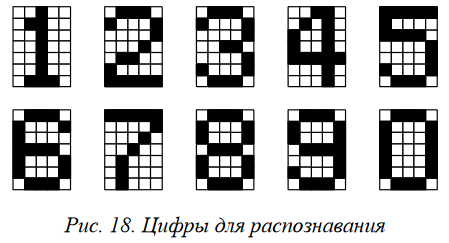

In [ ]:
# @title NeuralNetwork: ...classification numbers (view-matrix | size 5x7 | 0/1/2/3/4/5/6/7/8/9)

# 1 - Network
import numpy as np


def initialize_parameters_deep(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1])/np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

        assert (parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert (parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters


def linear_forward(A, W, b):
    Z = W.dot(A) + b

    assert (Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)

    return Z, cache


def softmax(Z):
  expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))
  A = expZ / np.sum(expZ, axis=0, keepdims=True)
  cache = Z
  return A, cache


def relu(Z):
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    cache = Z
    return A, cache


def linear_activation_forward(A_prev, W, b, activation):

    Z, linear_cache = linear_forward(A_prev, W, b)
    if activation == "relu":
        A, activation_cache = relu(Z)
    elif activation == "softmax":
        A, activation_cache = softmax(Z)

    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache


def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "softmax")
    caches.append(cache)

    assert (AL.shape == (parameters['W' + str(L)].shape[0], X.shape[1]))

    return AL, caches


def compute_cost(AL, Y, parameters, lambd):
    m = Y.shape[1]
    cross_entropy_cost = (-1 / m) * np.sum(Y * np.log(AL))

    L2_regularization_cost = 0
    L = len(parameters) // 2
    for l in range(1, L + 1):
        L2_regularization_cost += (1 / m) * (lambd / 2) * np.sum(np.square(parameters['W' + str(l)]))

    cost = cross_entropy_cost + L2_regularization_cost
    cost = np.squeeze(cost)
    assert (cost.shape == ())

    return cost


def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m)*np.dot(dZ, A_prev.T)
    db = (1/m)*np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)

    return dA_prev, dW, db


def relu_backward(dA, activation_cache):
    Z = activation_cache
    dZ = np.array(dA, copy=True)

    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)

    return dZ


def softmax_backward(dA, activation_cache):
    return dA


def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "softmax":
        dZ = softmax_backward(dA, activation_cache)

    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db


def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    dAL = AL - Y

    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "softmax")

    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads


def update_parameters(parameters, grads, learning_rate):

    L = len(parameters) // 2

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters




# ************************************************************************************************************************************************************
# ************************************************************************************************************************************************************
# ************************************************************************************************************************************************************




# Training
def training(model, X, Y, learning_rate, num_epochs, batch_size, lambd, step__output__cost, flag__output):
  parameters = initialize_parameters_deep(model)
  X = np.array(X).reshape(len(X), -1).T
  Y = np.eye(10)[Y].T

  m = X.shape[1]

  for i in range(num_epochs):
    # mix data
    permutation = np.random.permutation(m) # mix indexes
    X_shuffled = X[:, permutation]
    Y_shuffled = Y[:, permutation]

    # train by batch
    for start in range(0, m, batch_size):
      end = min(start + batch_size, m)
      X_batch = X_shuffled[:, start:end]
      Y_batch = Y_shuffled[:, start:end]

      AL, caches = L_model_forward(X_batch, parameters)
      cost = compute_cost(AL, Y_batch, parameters, lambd)
      grads = L_model_backward(AL, Y_batch, caches)
      parameters = update_parameters(parameters, grads, learning_rate)


    if i % step__output__cost == 0 and flag__output:
      print(f"Cost after epoch {i}: {cost}")

  return parameters


#
def print_array(array):
  for j in range(len(array)):
    for i in range(len(array[j])):
      print(f"{array[j][i]:10.3}", end="  ")
    print()
  print()
#


def predict(X, parameters):
    X = np.array(X).reshape(len(X), -1).T
    probas, caches = L_model_forward(X, parameters)
    print_array(probas)
    return np.argmax(probas, axis=0)











train_x = [[[0, 1, 1, 1, 0],
            [1, 0, 0, 0, 1],
            [1, 0, 0, 0, 1],
            [1, 0, 0, 0, 1],
            [1, 0, 0, 0, 1],
            [1, 0, 0, 0, 1],
            [0, 1, 1, 1, 0]],

           [[0, 0, 1, 0, 0],
            [0, 1, 1, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 1, 1, 1, 0]],

           [[0, 1, 1, 1, 0],
            [1, 0, 0, 0, 1],
            [0, 0, 0, 0, 1],
            [0, 0, 0, 1, 0],
            [0, 1, 1, 0, 0],
            [1, 0, 0, 0, 0],
            [1, 1, 1, 1, 1]],

           [[0, 1, 1, 1, 0],
            [1, 0, 0, 0, 1],
            [0, 0, 0, 0, 1],
            [0, 0, 1, 1, 0],
            [0, 0, 0, 0, 1],
            [1, 0, 0, 0, 1],
            [0, 1, 1, 1, 0]],

           [[0, 0, 1, 1, 0],
            [0, 1, 0, 1, 0],
            [1, 0, 0, 1, 0],
            [1, 0, 0, 1, 0],
            [1, 1, 1, 1, 1],
            [0, 0, 0, 1, 0],
            [0, 0, 0, 1, 0]],

           [[1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0],
            [1, 1, 1, 1, 0],
            [0, 0, 0, 0, 1],
            [0, 0, 0, 0, 1],
            [1, 0, 0, 0, 1],
            [0, 1, 1, 1, 0]],

           [[0, 1, 1, 1, 0],
            [1, 0, 0, 0, 1],
            [1, 0, 0, 0, 0],
            [1, 1, 1, 1, 0],
            [1, 0, 0, 0, 1],
            [1, 0, 0, 0, 1],
            [0, 1, 1, 1, 0]],

           [[1, 1, 1, 1, 1],
            [0, 0, 0, 0, 1],
            [0, 0, 0, 1, 0],
            [0, 0, 1, 0, 0],
            [0, 1, 0, 0, 0],
            [0, 1, 0, 0, 0],
            [0, 1, 0, 0, 0]],

           [[0, 1, 1, 1, 0],
            [1, 0, 0, 0, 1],
            [1, 0, 0, 0, 1],
            [0, 1, 1, 1, 0],
            [1, 0, 0, 0, 1],
            [1, 0, 0, 0, 1],
            [0, 1, 1, 1, 0]],

           [[0, 1, 1, 1, 0],
            [1, 0, 0, 0, 1],
            [1, 0, 0, 0, 1],
            [0, 1, 1, 1, 1],
            [0, 0, 0, 0, 1],
            [1, 0, 0, 0, 1],
            [0, 1, 1, 1, 0]]]


train_y = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


# hyperparameters
model = [35, 64, 64, 10]
learning_rate = 0.045 #0.067
num_epochs = 5000
batch_size = 32
lambd = 0
step__output__cost = int(num_epochs / 10)
flag__output = True

trained_parameters = training(model, train_x, train_y, learning_rate, num_epochs, batch_size, lambd, step__output__cost, flag__output)



# test = train
predictions = predict(train_x, trained_parameters)
print("test = train", end="\n")
print("predictions: ", end="")
print(predictions)
print("true labels: ", end="")
train_y = np.array(train_y)
print(train_y)
accuracy = 0
for i in range(len(train_y)):
  if train_y[i] == predictions[i]:
    accuracy += 1
accuracy = accuracy / len(train_y)
print(f"Accuracy = {accuracy}")











def print_nums(nums, r, c):
  for num in nums:
    for i in range(r):
      for j in range(c):
        print(num[i][j], end=" ")
      print()
    print()


import random


def generate_tests(numbers, num_examples):
  data_x = []
  data_y = []
  k = 0

  for num in numbers:
    indices = [(i, j) for i in range(len(num)) for j in range(len(num[i])) if num[i][j] == 1]
    t = int(len(indices) * 0.3)   # how much to remove "1", 30%

    for _ in range(num_examples):
      temp_num = [row[:] for row in num]
      delete_indices = random.sample(indices, t)
      for i, j in delete_indices:
        temp_num[i][j] = 0

      data_x.append(temp_num)
      data_y.append(k)
    k += 1

  return data_x, data_y



# test = generate_tests()
test_x, test_y = generate_tests(train_x, 5)
predictions = predict(test_x, trained_parameters)
print("test = generate_tests()", end="\n")
print("predictions: ", end="")
print(predictions)
print("true labels: ", end="")
test_y = np.array(test_y)
print(test_y)
accuracy = 0
incoreccted = []
for i in range(len(test_y)):
  if test_y[i] == predictions[i]:
    accuracy += 1
  else:
    print_nums([test_x[i]], 7, 5)
    print(f"prediction: {predictions[i]}, true label: {test_y[i]}", end="\n")
    print("-----------------")
    print()
accuracy = accuracy / len(test_y)
print(f"Accuracy = {accuracy}")

Cost after epoch 0: 2.3371581641914974
Cost after epoch 500: 0.019118037273825286
Cost after epoch 1000: 0.0061945898644724445
Cost after epoch 1500: 0.003419553773386123
Cost after epoch 2000: 0.0022909074666991507
Cost after epoch 2500: 0.0016938190820505721
Cost after epoch 3000: 0.0013293783146892987
Cost after epoch 3500: 0.001086352272592197
Cost after epoch 4000: 0.0009137808847283068
Cost after epoch 4500: 0.0007856901081232299
     0.999     1.3e-06    6.23e-06    7.43e-06    2.79e-06    0.000248    0.000277    2.09e-07    3.25e-05    9.11e-06  
  1.91e-06         1.0    9.69e-07    9.14e-05    5.68e-05    1.18e-05     2.8e-06    2.68e-05    1.46e-05    1.43e-05  
  4.56e-06    6.85e-06         1.0    0.000318    1.48e-05    1.15e-06     3.2e-08    4.83e-05    8.44e-07    7.79e-07  
  1.06e-06    0.000146     0.00036       0.999    2.89e-06     4.1e-06    1.07e-06    2.46e-05    0.000261    0.000288  
  9.04e-07    9.41e-05    1.99e-06    1.61e-05         1.0    1.44e-07    9.